In [242]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import itertools
import colorlover as cl
import random
import plotly.graph_objs as go
import sys

from datetime import datetime, timedelta, date
from collections import defaultdict
from sklearn.ensemble import IsolationForest
from plotly.offline import init_notebook_mode, plot, iplot

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

## ML models

In [288]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean(axis=1))

def mse(predictions, targets):
    return((predictions - targets) ** 2).mean(axis=1)

def mae(predictions, targets):
    return (abs(predictions - targets)).mean(axis=1)

In [80]:
def predict(model, X):
    
    model_predict = pd.DataFrame()
    host_cons = [(host,group) for host,group in X.drop_duplicates(['host', 'consumer_group'])[['host', 'consumer_group']].values]
    
    for (host,consumer_group) in host_cons:
        sample = X[(X.host == host) & (X.consumer_group == consumer_group)].set_index(['time', 'host', 'consumer_group'])
        predict = model.fit(sample).predict(sample)        
        model_predict = pd.concat([model_predict, pd.DataFrame(predict, columns=['is_anomaly'])], sort=False)
        
    return pd.concat([X[['time','host','consumer_group']], model_predict.reset_index(drop=True)], axis=1, sort=False)

Базовая идея метода «Локального уровня выброса» — сравнение локальной плотности точки с плотностями её соседей. 
Точка A имеет меньшую плотность по сравнению с соседями
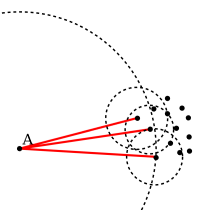

## Autoencoders

In [219]:
def vae_predict(X, noise=0):
    
    original_dim = X.shape[1]

    def sampling(args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon


    # network parameters
    input_shape = (original_dim, )
    intermediate_dim = 64
    batch_size = 64
    latent_dim = 2
    epochs = 100

    # VAE model = encoder + decoder
    # build encoder model
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    
    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')
    
    reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    vae.compile(optimizer='adam')
    vae.summary()


    earlystopper = EarlyStopping(monitor='val_loss', patience=5)
    # train the autoencoder
    vae.fit(X,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1,
            callbacks=[earlystopper])
    
    vae_predict = vae.predict(X)
    
    mse_ = pd.DataFrame(np.mean(np.power(X.values - vae_predict, 2), axis=1),columns=['mse'])
    error_ae = pd.concat([X.reset_index()[['time','host','consumer_group']], mse_],axis=1,sort=False)

    plt.plot(error_ae[['time']], error_ae[['mse']], '*')
    plt.xticks(rotation='vertical')
    
    return error_ae



In [324]:
def noise_autoencoder(X, noise=0, repeat=3):
    
    dim = X.shape[1]    
    
    X_real = np.repeat(X, repeat, axis=0)
    noise_array = noise * np.random.normal(loc=0.0, scale=1.0, size=[X.shape[0] * 3, X.shape[1]])
    X_noise = np.clip(X_real + noise_array, 0, 1)
    
    X_input = Input(shape=(dim,))
    encoded = Dense(128, activation='relu')(X_input)
    encoded = Dense(64, activation='linear', activity_regularizer=regularizers.l1(10e-5))(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(dim, activation='sigmoid')(decoded)
    
    autoencoder = Model(X_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    earlystopper = EarlyStopping(monitor='val_loss', patience=5)
    autoencoder.fit(X_noise, 
                    X_real,
                    epochs=1000,
                    batch_size=128,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[earlystopper])

    return autoencoder.predict(X)


## Visualization

In [46]:
def show_forecast(X, metrics, consumer_group, anomaly=None):
    ''' Visualization function
    '''
    
    # бага с legend doubleclick

    colors=[color for color in cl.flipper()['seq']['9'].values()]
    data_host=defaultdict(list)

    hosts=X.host.unique()
    for i,host in enumerate(hosts):
        fact_data=[]
        if i==0: 
            ButtonVisible=True
        else: 
            ButtonVisible=False

        anomaly_data = [go.Scatter(
            x=[anomaly[anomaly.host==host].iloc[i].time,anomaly[anomaly.host==host].iloc[i].time+timedelta(hours=1)],
            y=[1,1],
            fill='tozeroy',
            fillcolor='rgba(190,127,188,0.5)',
            line=dict(width=0),
            mode= 'none',
            showlegend=False,
            visible=ButtonVisible
        ) for i in range(len(anomaly[anomaly.host==host]))]
        
           
        # фактические значения
        for j,metric in enumerate(metrics):
            
            dash='longdash'
            
            if j%2==0:
                dash='solid'
            elif j%3==0:
                dash='dash'
            elif j%5==0:
                dash='dot'

            
            if (ButtonVisible==True) & (j!=0): 
                ButtonVisible='legendonly'
                
            colorpal=random.randint(0,len(colors)-1)
            fact_data.append(go.Scatter(
                name=str(metric),
                #legendgroup=str(metric),     
                #showlegend= False,
                x=X[X.host==host].time,
                y=X[X.host==host][metric].values,
                mode='lines',
                line=dict(color=colors[colorpal][i+3],
                          dash=dash,
                          width=2
                           ),
                visible=ButtonVisible
                )) 

        data_host[host]=list(filter(None.__ne__,[*fact_data,*anomaly_data]))

    updatemenus = list([
    dict(type="buttons",
         x = -0.07,
         buttons=list([
        dict(label='Host '+str(hostname),
          method = 'update',
          args = [
              {'visible':list(itertools.chain.from_iterable([([True]+(len(metrics)-1)*['legendonly']+(len(values)-len(metrics))*[True]) if host==hostname else len(values)*[False] for host,values in data_host.items()]
          )) },
             ])
        for i,hostname in enumerate(hosts) 
         ])
        )
 ])


    layout = dict(title=consumer_group, 
                  showlegend=True,
                  updatemenus=updatemenus,

                  xaxis=dict(
                      range=['2018-11-12','2018-11-14'],
                      rangeselector=dict(
                          buttons=list([
                              dict(count=1,
                                   label='1d',
                                   step='day',
                                   stepmode='backward'),
                              dict(count=7,
                                   label='1w',
                                   step='day',
                                   stepmode='backward'),
                              dict(count=1,
                                   label='1m',
                                   step='month',
                                   stepmode='backward'),
                              dict(step='all',
                                   stepmode='backward')
                          ]),
                      ),
                      rangeslider=dict(
                          visible = True
                      ),
                      type='date'
                  ),
                  yaxis=dict(
                      ticks='outside',
                      zeroline=False
                  ),
                 )
    return dict(data=list(itertools.chain.from_iterable([value for key,value in data_host.items()])), layout=layout)


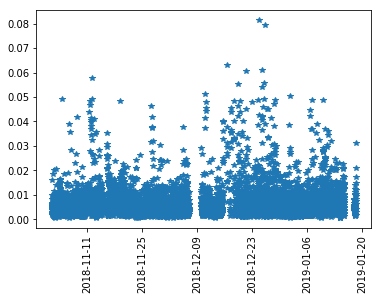

In [325]:
# if __name__ == "__main__":
    
#    outliers_fraction = float(sys.argv[1]) if len(sys.argv) > 1 else 0.015

if True:
    
    df = pd.read_csv('../features/clear_data/rm_features.csv', ';', infer_datetime_format=True, parse_dates=['time'])
    X = df.set_index(['time', 'host', 'consumer_group'])

    # AutoEncoder
    autoencoder_predict = noise_autoencoder(X.values, 0.2)
    autoencoder_error = pd.concat([X.reset_index()[['time','host','consumer_group']], pd.DataFrame(mse(autoencoder_predict, X.values), columns=['error'])], axis=1, sort=False)
    outliers_fraction = 0.01
    autoencoder_error['quantile_error'] = autoencoder_error.groupby(['host','consumer_group'])['error'].transform(lambda x: x.quantile(1 - outliers_fraction))
    
    anomaly_predict = autoencoder_error.query('error > quantile_error')
    plt.plot(autoencoder_error[['time']], autoencoder_error[['error']], '*')
    plt.xticks(rotation='vertical')  
    
    # Visualization
    for consumer_group in anomaly_predict.consumer_group.unique():
        fig_reqs = show_forecast(X.query('consumer_group == @consumer_group').reset_index(), X.columns, consumer_group, anomaly_predict[anomaly_predict.consumer_group == consumer_group])
        #iplot(fig_reqs)

        plot(fig_reqs, filename='../results/report_{0}.html'.format(consumer_group))
